In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json

import scanpy
import anndata
import shap
import xgboost

from tqdm import tqdm

from pprint import pprint
import warnings


shap.initjs()

In [17]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

 with the number of misclassified individuals increasing to 60 for females and 52 for males (see Figure 1S), resulting in accuracy 0.83.

In [18]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'

organ = ['BRAIN0', "HEART", "BRAIN1", 'None'][-1]

#! SHOLD BE THE SAME AS IN train_model.py
# feature_importance_method = 'native'
feature_importance_method = 'SHAP'


value_to_predict = 'Sex'

sex = ['chrXY', 'chrX', 'chrY', 'autosome'][-1]
organ, sex

('None', 'autosome')

In [19]:
with open(f'../models/{model_type}.json', 'r') as file:
    model_params = json.load(file)

if model_type == 'xgboost':
    model = xgb.XGBClassifier(**model_params)

(667, 82)


0it [00:00, ?it/s]

6
13


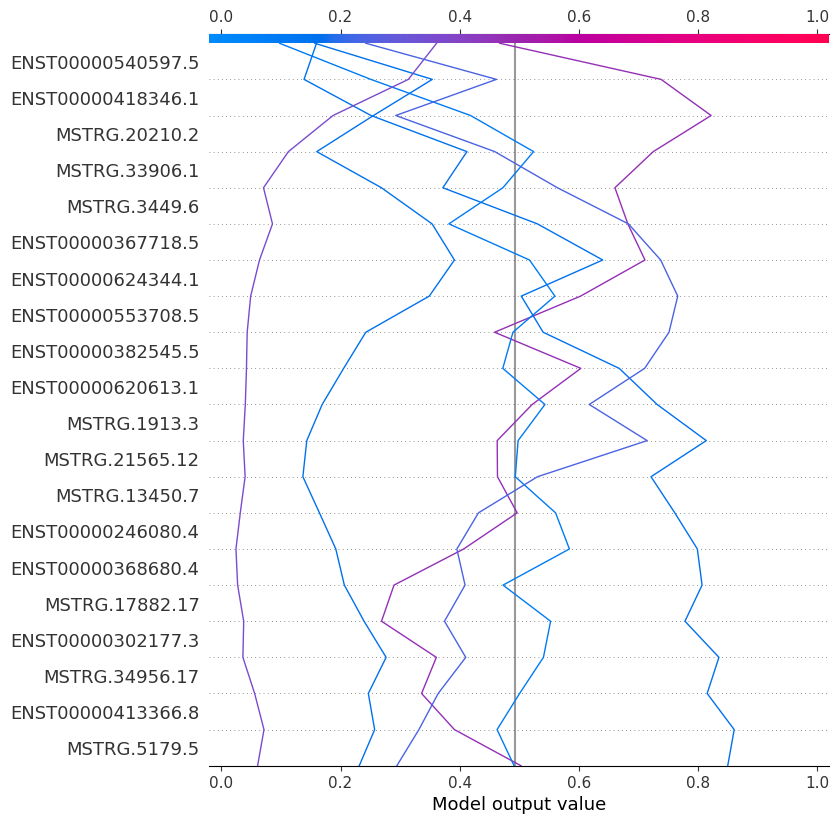

1it [00:01,  1.37s/it]

6
15


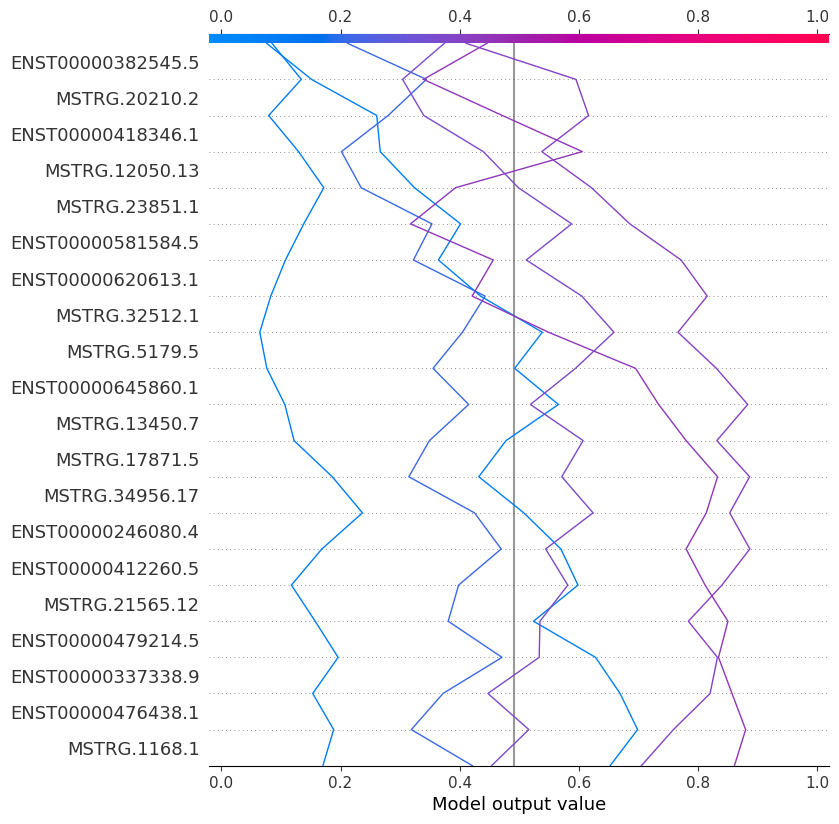

2it [00:02,  1.36s/it]

12
15


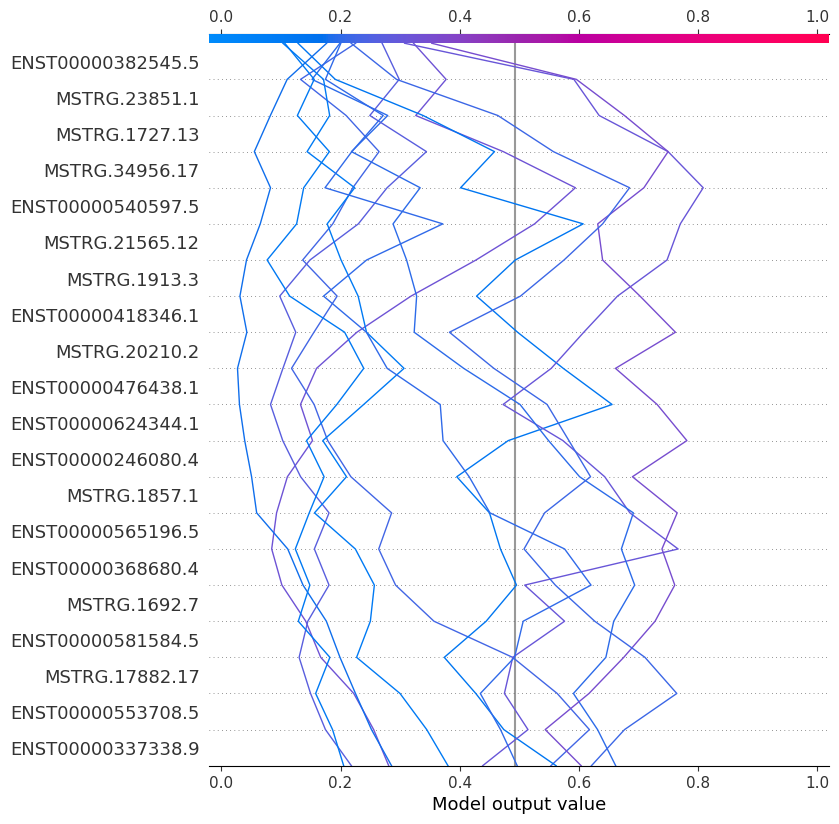

3it [00:03,  1.31s/it]

16
12


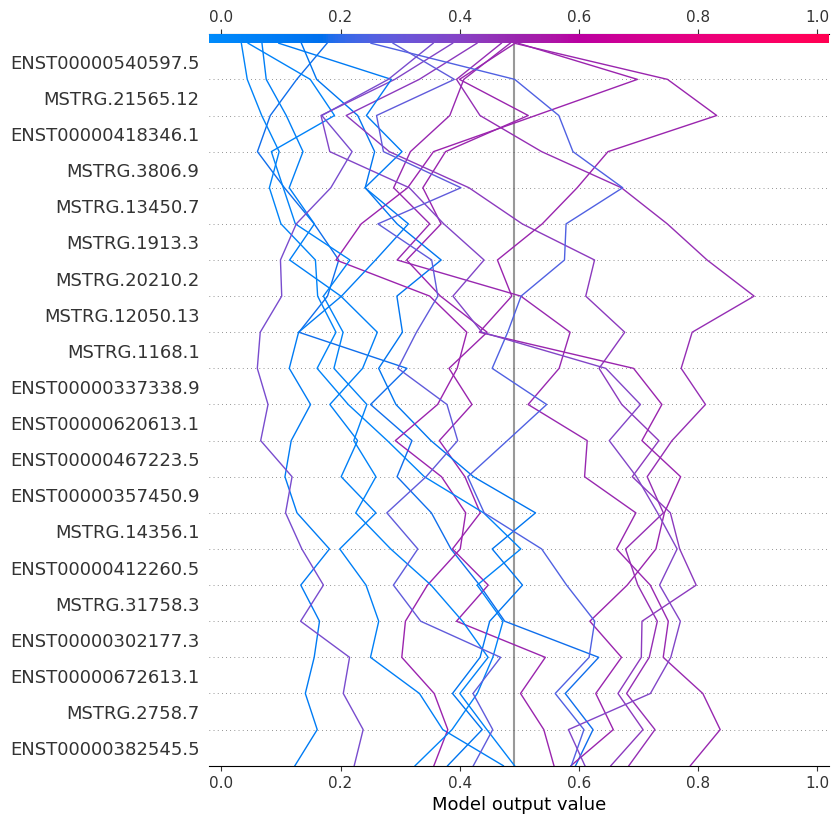

4it [00:05,  1.30s/it]

12
5


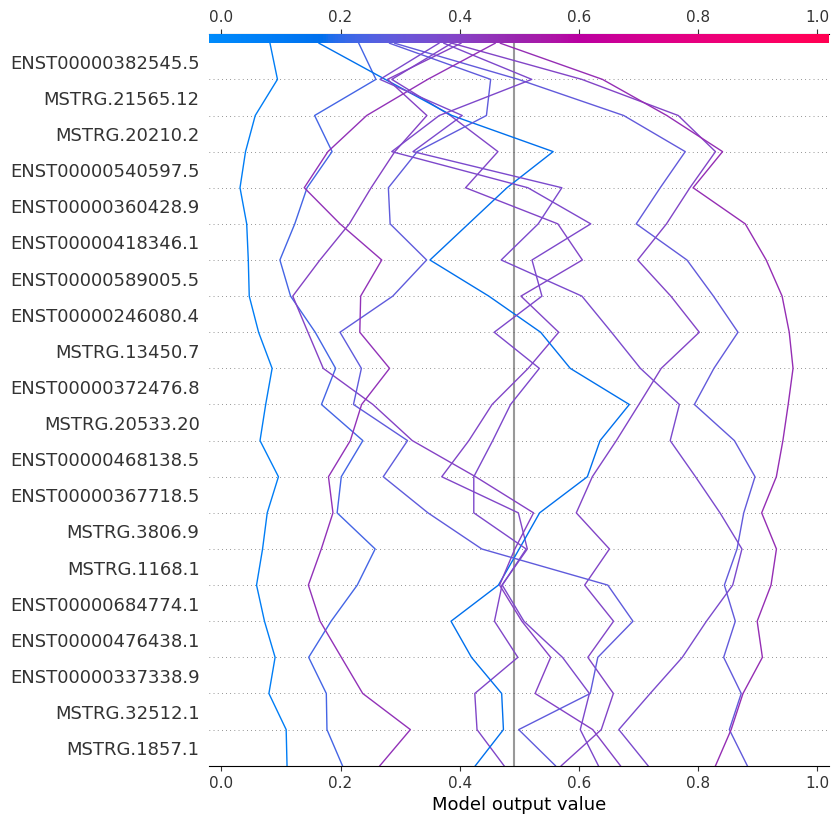

5it [00:06,  1.33s/it]

--------------------
mean_accuracy=0.8320278307709573,
mean_f1=0.8313231327016455,
mean_precision=0.8246070846232844,
mean_recall=0.841864801864802,
--------------------
```
                    SHAP
Feature                 
ENST00000418346.1     50
ENST00000540597.5     50
ENST00000382545.5     50
MSTRG.21565.12        49
MSTRG.13450.7         48
...                  ...
MSTRG.16471.18        13
ENST00000358747.10    13
MSTRG.1692.7          13
ENST00000553708.5     13
MSTRG.33150.3         13

[82 rows x 1 columns]


In [20]:

data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)
data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')


features_fname = f"geuvadis_train_features_{sex}_calibration_{organ}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

data = data[features_list.index]
print(data.shape)

X = data
y = data_header['Sex']

cv = StratifiedKFold(n_splits=5)

label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)
# X_train = data.values

# scaler = RobustScaler().fit(X_train)
# X_train = scaler.transform(X_train)

# y_train = data_header['Sex'].values
# # print(y_train)
# y_train = LabelEncoder().fit_transform(y_train)

# proba = np.zeros(shape=(X_train.shape[0], 2))
# pred = np.zeros(shape=(X_train.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []


preds = np.zeros(shape=y.shape)
preds_proba = np.zeros(shape=y.shape)

shap_values_tot = np.zeros(shape=(len(y), len(features_list)))

false_male = []
false_female = []

true_male = []
true_female = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    # if i > 0: 
    #     continue

    X_train = X.iloc[train]
    y_train = y[train]
    X_test = X.iloc[val]
    y_test = y[val]
    
    train_scaler = RobustScaler().fit(X_train)
    test_scaler = RobustScaler().fit(X_test)

    X_train = pd.DataFrame( train_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame( test_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    X_train_ = X_train
    y_train_ = y_train
    X_val = X_test
    y_val = y_test

    model = xgb.XGBClassifier(**model_params)
    saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)
    
    false_male_ = [val[j] for j in range(len(pred)) if pred[j] == 1 and y_val[j] == 0]
    false_female_ = [val[j] for j in range(len(pred)) if pred[j] == 0 and y_val[j] == 1]
    
    false_male_ids = [j for j in range(len(pred)) if pred[j] == 1 and y_val[j] == 0]
    false_female_ids = [j for j in range(len(pred)) if pred[j] == 0 and y_val[j] == 1]
    # print(len(false_female_ids))
    # print(len(false_male_ids))
    
    false_male.extend(false_male_)
    false_female.extend(false_female_)
    
    true_male_ = [val[j] for j in range(len(pred)) if pred[j] == 1 and y_val[j] == 1]
    true_female_ = [val[j] for j in range(len(pred)) if pred[j] == 0 and y_val[j] == 0]
    
    true_male_ids = [j for j in range(len(pred)) if pred[j] == 1 and y_val[j] == 1]
    true_female_ids = [j for j in range(len(pred)) if pred[j] == 0 and y_val[j] == 0]
    
    true_male.extend(true_male_)
    true_female.extend(true_female_)
        
    preds[val] = pred
    preds_proba[val] = pred_prob[:, 1]

    # proba += model.predict_proba(X_train)
    # pred_ = model.predict(X_train)
    # # if sex == 'autosome':
    # #     pred_ = np.abs(pred_ - 1)
    # pred += pred_

    accuracies.append(accuracy_score(y_test, pred))
    f1.append(f1_score(y_test, pred))
    precisions.append(precision_score(y_test, pred))
    recalls.append(recall_score(y_test, pred))
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap_interaction_values = explainer.shap_interaction_values(X_val)
    # shap.summary_plot(shap_values, X_train, feature_names=data.columns,)
    
    shap.decision_plot(explainer.expected_value, 
                       shap_values[false_female_ids], 
                       X_val.iloc[false_female_ids], 
                    #    feature_names=data.columns.to_list(),
                       link="logit"
                       )
    shap_values_tot[val] =  shap_values

mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
# print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

print(features_list)

In [21]:
X.iloc[train]

ENST00000418346.1  ENST00000540597.5  ENST00000382545.5  \
ERR188021           0.066315           3.222748           0.550137   
ERR188022           0.641015           0.062257           0.000000   
ERR188023           0.517444           0.033054           0.226500   
ERR188024           0.000000           1.784280           0.949955   
ERR188025           0.821475           0.000000           0.117734   
...                      ...                ...                ...   
ERR188421           0.126403           0.000000           0.077838   
ERR188422           0.212110           0.000000           0.803086   
ERR204838           0.000000           0.000000           0.088693   
ERR204839           0.405600           0.084283           0.304270   
ERR204842           0.000000           0.000000           0.091914   

           MSTRG.21565.12  MSTRG.13450.7  MSTRG.1913.3  MSTRG.20210.2  \
ERR188021        0.000000       0.331404      1.879362       0.135070   
ERR188022        0.000000       0.312306      0.561952       0.486075   
ERR188023        1.471592       0.021934      0.169051       0.080074   
ERR188024        0.000000       0.000000      1.068493       1.715455   
ERR188025        0.000000       0.433328      0.495171       0.110553   
...                   ...            ...           ...            ...   
ERR188421        0.000000       0.469493      0.275611       0.659819   
ERR188422        1.090820       0.021191      0.000000       0.210098   
ERR204838        0.000000       0.000000      0.724897       0.119441   
ERR204839        0.000000       0.728430      1.124171       0.692584   
ERR204842        0.000000       0.000000      0.593169       2.719760   

           ENST00000372476.8  MSTRG.1168.1  ENST00000479214.5  ...  \
ERR188021           0.371820      0.448089           0.000000  ...   
ERR188022           0.000000      0.343467           0.000000  ...   
ERR188023           0.524604      1.178407           0.859930  ...   
ERR188024           0.000000      1.179953           1.107362  ...   
ERR188025           0.000000      0.717738           0.742024  ...   
...                      ...           ...                ...  ...   
ERR188421           0.000000      0.779993           1.128222  ...   
ERR188422           4.128323      0.062821           0.000000  ...   
ERR204838           0.105789      0.629637           1.337077  ...   
ERR204839           2.395423      0.277750           1.278770  ...   
ERR204842           2.031537      0.388618           0.000000  ...   

           ENST00000615215.4  MSTRG.5179.5  MSTRG.34322.14  MSTRG.2758.7  \
ERR188021           0.000000      0.045148        1.843687      0.009528   
ERR188022           0.000000      0.709875        0.000000      0.000000   
ERR188023           0.000000      0.000000        0.000000      0.972079   
ERR188024           0.000000      2.184444        0.000000      0.214027   
ERR188025           1.537631      0.049076        3.329168      0.366926   
...                      ...           ...             ...           ...   
ERR188421           0.000000      0.000000        3.559554      3.374568   
ERR188422           0.000000      1.164311        1.462050      0.244445   
ERR204838           0.000000      2.371913        0.000000      0.000000   
ERR204839           0.000000      1.478698        2.002250      0.000000   
ERR204842           0.003122      0.000000        0.000000      0.221625   

           MSTRG.31525.1  MSTRG.16471.18  ENST00000358747.10  MSTRG.1692.7  \
ERR188021       0.636531        0.000000            1.583513      1.082703   
ERR188022       0.000000        0.001606            0.577644      2.123200   
ERR188023       0.976831        0.000000            0.452103      0.267296   
ERR188024       0.463990        0.428394            0.000000      0.291695   
ERR188025       0.245305        1.344443            0.000000      0.820893   
...                  ...             ...                 ...           

In [32]:
# false_male
X.iloc[X[false_male]]

ENST00000418346.1  ENST00000540597.5  ENST00000382545.5  \
ERR188021           0.066315           3.222748           0.550137   
ERR188022           0.641015           0.062257           0.000000   
ERR188023           0.517444           0.033054           0.226500   
ERR188024           0.000000           1.784280           0.949955   
ERR188025           0.821475           0.000000           0.117734   
...                      ...                ...                ...   
ERR204940           4.353014           3.227829           3.257101   
ERR205020           1.376057           2.449471           1.800687   
ERR205021           0.882831           0.127039           0.254760   
ERR205022           0.220971           2.485482           0.682510   
ERR205023           0.366261           0.000000           3.926716   

           MSTRG.21565.12  MSTRG.13450.7  MSTRG.1913.3  MSTRG.20210.2  \
ERR188021        0.000000       0.331404      1.879362       0.135070   
ERR188022        0.000000       0.312306      0.561952       0.486075   
ERR188023        1.471592       0.021934      0.169051       0.080074   
ERR188024        0.000000       0.000000      1.068493       1.715455   
ERR188025        0.000000       0.433328      0.495171       0.110553   
...                   ...            ...           ...            ...   
ERR204940        0.000000       1.121803      0.000000       2.747363   
ERR205020        0.000000       0.000000      0.251156       1.214706   
ERR205021        0.000000       1.535681      0.761626       0.295017   
ERR205022        0.000000       0.132270      0.446839       0.141214   
ERR205023        0.159065       0.000000      2.438788       2.471015   

           ENST00000372476.8  MSTRG.1168.1  ENST00000479214.5  ...  \
ERR188021           0.371820      0.448089           0.000000  ...   
ERR188022           0.000000      0.343467           0.000000  ...   
ERR188023           0.524604      1.178407           0.859930  ...   
ERR188024           0.000000      1.179953           1.107362  ...   
ERR188025           0.000000      0.717738           0.742024  ...   
...                      ...           ...                ...  ...   
ERR204940           0.000000      2.946633           0.000000  ...   
ERR205020           1.593257      0.126522           0.000000  ...   
ERR205021           0.831338      0.595642           1.695369  ...   
ERR205022           1.753175      0.000000           0.000000  ...   
ERR205023           0.000000      0.000000           1.098725  ...   

           ENST00000615215.4  MSTRG.5179.5  MSTRG.34322.14  MSTRG.2758.7  \
ERR188021           0.000000      0.045148        1.843687      0.009528   
ERR188022           0.000000      0.709875        0.000000      0.000000   
ERR188023           0.000000      0.000000        0.000000      0.972079   
ERR188024           0.000000      2.184444        0.000000      0.214027   
ERR188025           1.537631      0.049076        3.329168      0.366926   
...                      ...           ...             ...           ...   
ERR204940           0.139629      0.000000        1.103197      0.000000   
ERR205020           0.469844      1.113130        0.549020      2.269824   
ERR205021           1.673589      0.000000        0.000000      0.666316   
ERR205022           0.000000      0.020052        0.008286      0.099053   
ERR205023           0.000000      0.772887        3.430809      0.000000   

           MSTRG.31525.1  MSTRG.16471.18  ENST00000358747.10  MSTRG.1692.7  \
ERR188021       0.636531        0.000000            1.583513      1.082703   
ERR188022       0.000000        0.001606            0.577644      2.123200   
ERR188023       0.976831        0.000000            0.452103      0.267296   
ERR188024       0.463990        0.428394            0.000000      0.291695   
ERR188025       0.245305        1.344443            0.000000      0.820893   
...                  ...             ...                 ...           

60 52


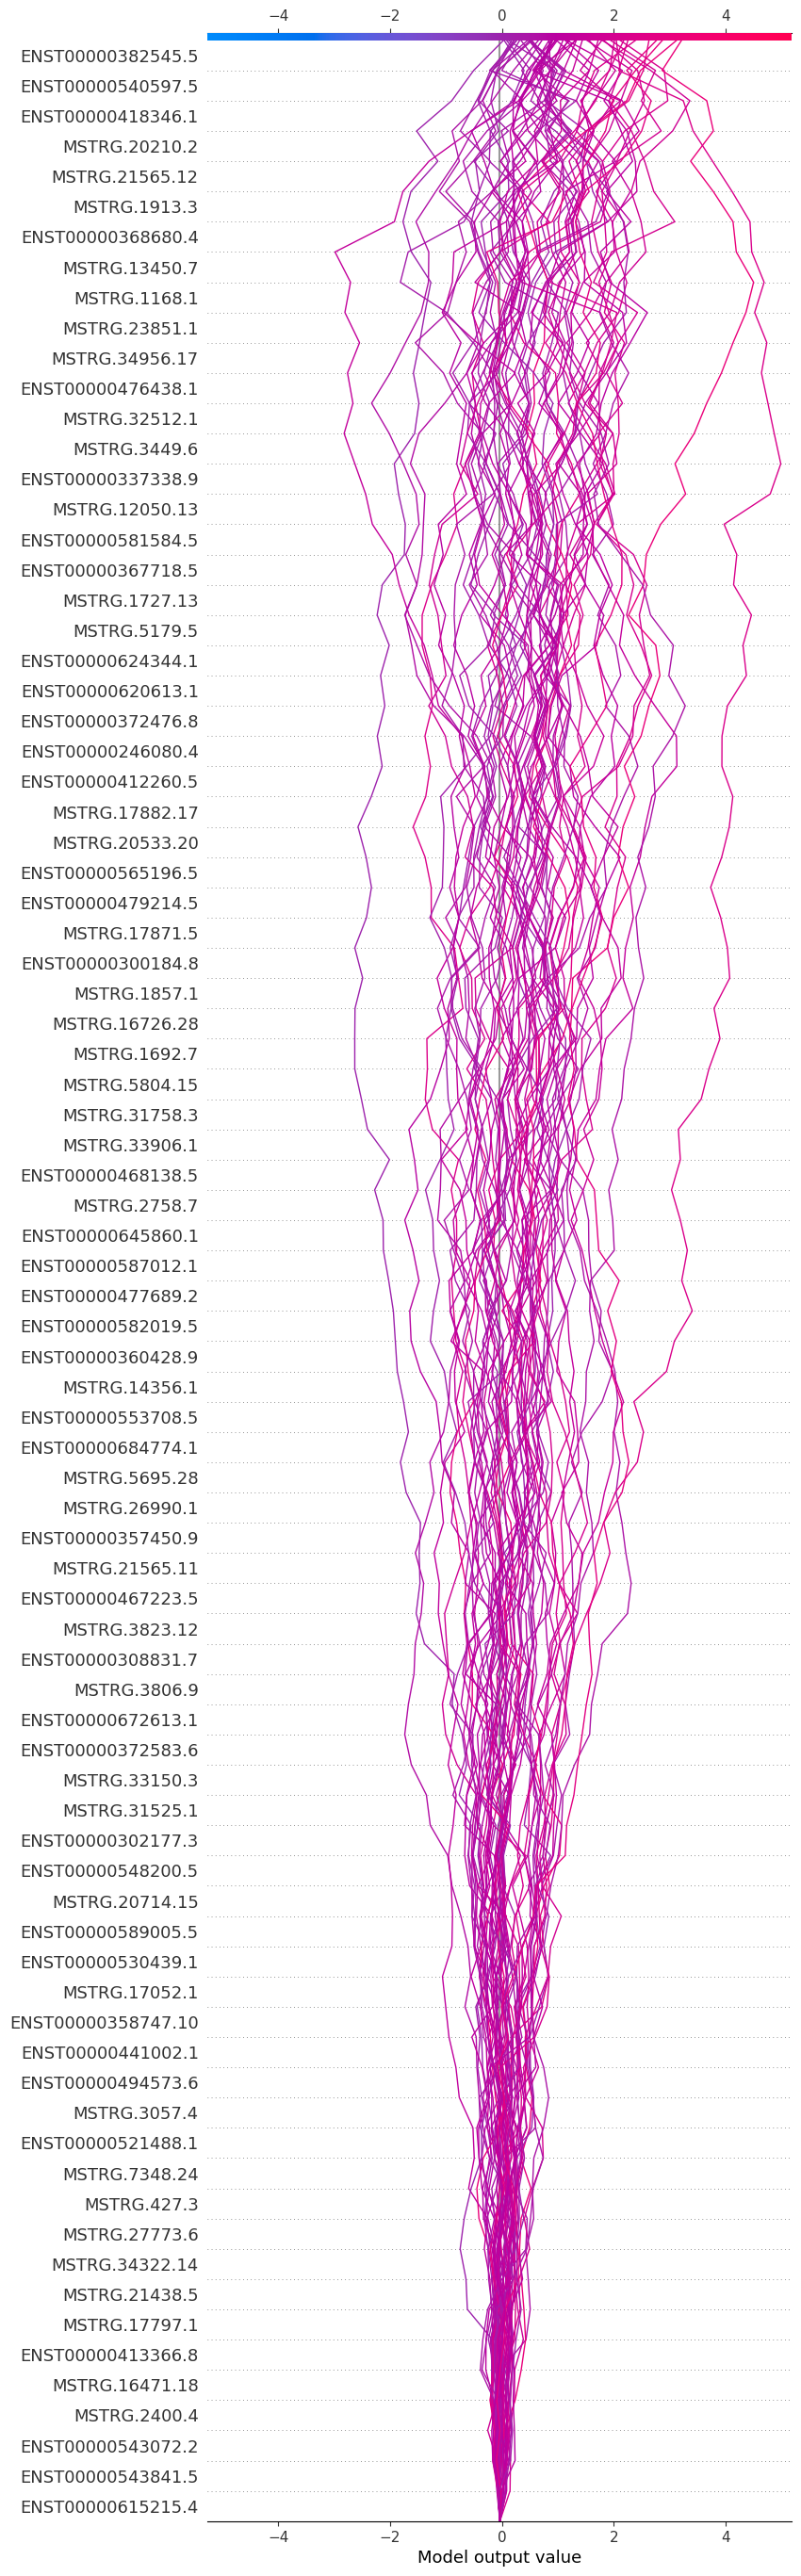

In [107]:
print(len(false_male), len(false_female))

# shap.decision_plot(explainer.expected_value,
#                    shap_values[false_male_ids], 
#                    X_val[false_male_ids], 
#                    feature_names=data.columns.to_list(),
#                 #    feature_display_range=range(len(features_list))
#                    #    highlight=false_male_ids,
#                 #    link="logit",
#                 #    feature_order='hclust'
                   
#                   )
# shap.decision_plot(explainer.expected_value,
#                    shap_interaction_values[false_male_ids[0]], 
#                    X_val[false_male_ids[0]], 
#                    feature_names=data.columns.to_list(),
#                    link="logit")
# shap.force_plot(
#     explainer.expected_value,
#     shap_values[false_male_ids[0]],
#     data.columns.to_list(),
#     link="logit",
#     # matplotlib=True,
# )

# false_male

r = shap.decision_plot(explainer.expected_value,
                   shap_values_tot[false_male], 
                   X.iloc[false_male], 
                   feature_names=data.columns.to_list(),
                   feature_display_range=range(len(features_list))[::-1],
                   #    highlight=false_male_ids,
                #    link="logit",
                  #  feature_order='hclust',
                   return_objects=True
                   
                  )

# len(shap_values[false_male_ids].sum(1) + y_val[false_male_ids] > 0.5)


### boxplots male - false male and female - false female

/tmp/ipykernel_23707/3498440089.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_pred['prediction'].iloc[false_male] = "FM"
/tmp/ipykernel_23707/3498440089.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

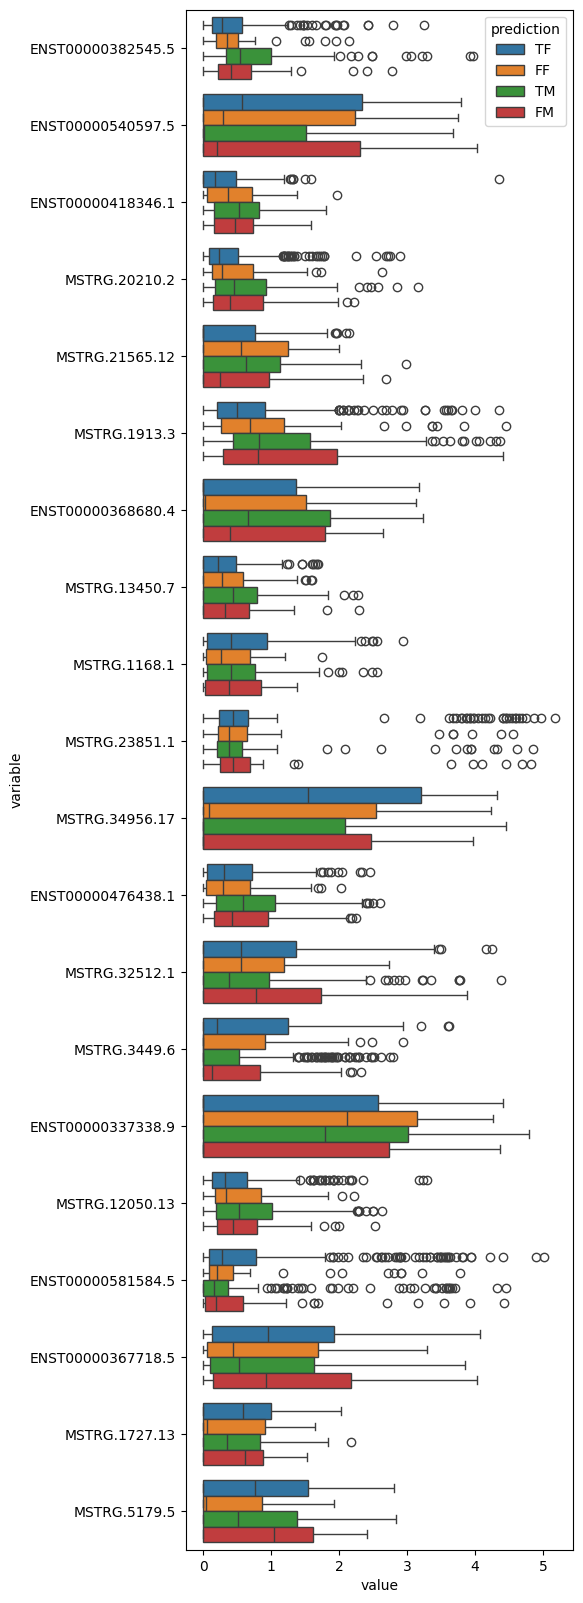

In [167]:
# sns.boxplot(X.iloc[:, :5])
# female_total =  X.iloc[false_female + true_female]
# male_total =  X.iloc[false_male + true_male]

features_sorted = X.iloc[:, np.argsort(np.abs(shap_values_tot[false_male]).sum(axis=0))[-20:][::-1]].columns

plt.figure(figsize=(5, 20))
X_pred = X.copy(deep=True)[features_sorted]

X_pred['prediction'] = ""
X_pred['prediction'].iloc[false_male] = "FM"
X_pred['prediction'].iloc[false_female] = "FF"
X_pred['prediction'].iloc[true_male] = "TM"
X_pred['prediction'].iloc[true_female] = "TF"


# female_total['groundtrue'] = np
# male_total['groundtrue'] = 0
# female_total['groundtrue'].iloc[true_female] = 1
# male_total['groundtrue'].iloc[true_male] = 1
# male_total
X_melted = pd.melt(X_pred, id_vars='prediction')
g = sns.boxplot(data=X_melted, y='variable', x='value', hue='prediction', orient='h',
                hue_order=['TF', 'FF', 'TM', 'FM'])
# plt.xticks(rotation=90)


# len(false_female + true_female)

In [163]:


# adata = anndata.AnnData(X=X_pred.drop(columns='prediction'))
# adata.obs = X_pred[['prediction']]

# # scanpy.pp.neighbors(adata)
# # scanpy.tl.umap(adata)
# # scanpy.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.5)

# # adata.obs
# scanpy.tl.rank_genes_groups(adata, groupby="prediction", method="wilcoxon")
# scanpy.pl.rank_genes_groups_dotplot(adata, groupby='prediction', 
#                                     standard_scale ='var',
#                                     # groups=['TF', "FF"],
#                                     var_names=features_sorted
#                                     )


(20,)

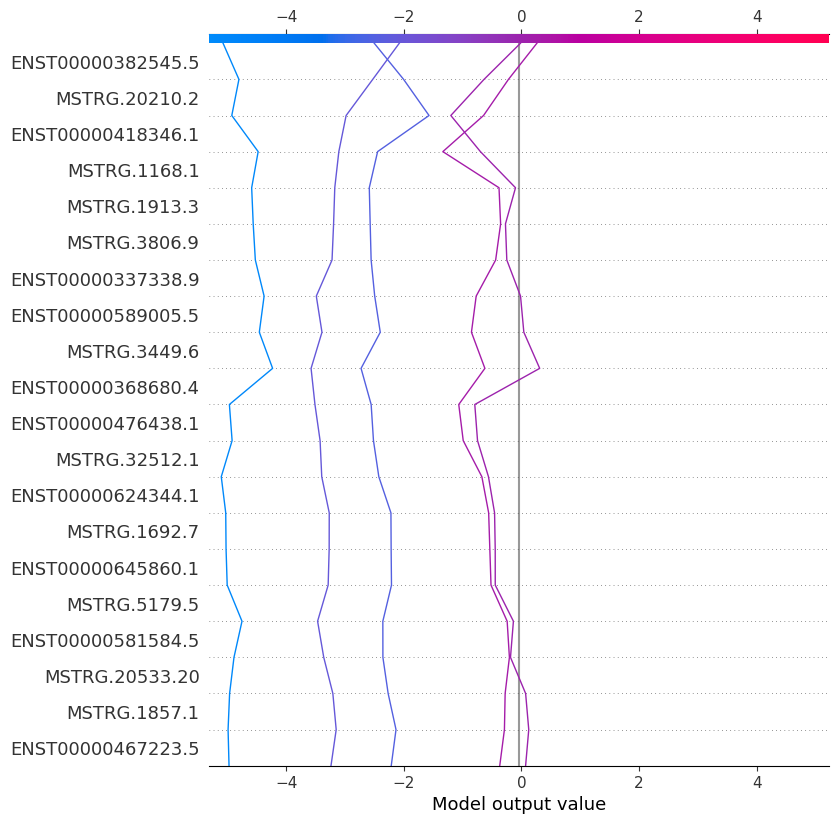

In [61]:
idx = np.argpartition(shap_values_tot[:, data.columns.get_loc('ENST00000540597.5')], 2)[:5]
idx

shap.decision_plot(
    explainer.expected_value,
    shap_values_tot[idx],
    data.columns.to_list(),
    feature_order=r.feature_idx,
    # xlim=r.xlim,
    # feature_display_range=range(len(features_list)),
)

# data.columns.get_loc('ENST00000382545.5')

Index(['ENST00000615215.4', 'ENST00000543841.5', 'ENST00000543072.2',
       'MSTRG.2400.4', 'MSTRG.16471.18', 'ENST00000413366.8', 'MSTRG.17797.1',
       'MSTRG.21438.5', 'MSTRG.34322.14', 'MSTRG.27773.6', 'MSTRG.427.3',
       'MSTRG.7348.24', 'ENST00000521488.1', 'MSTRG.3057.4',
       'ENST00000494573.6', 'ENST00000441002.1', 'ENST00000358747.10',
       'MSTRG.17052.1', 'ENST00000530439.1', 'ENST00000589005.5',
       'MSTRG.20714.15', 'ENST00000548200.5', 'ENST00000302177.3',
       'MSTRG.31525.1', 'MSTRG.33150.3', 'ENST00000372583.6',
       'ENST00000672613.1', 'MSTRG.3806.9', 'ENST00000308831.7',
       'MSTRG.3823.12', 'ENST00000467223.5', 'MSTRG.21565.11',
       'ENST00000357450.9', 'MSTRG.26990.1', 'MSTRG.5695.28',
       'ENST00000684774.1', 'ENST00000553708.5', 'MSTRG.14356.1',
       'ENST00000360428.9', 'ENST00000582019.5', 'ENST00000477689.2',
       'ENST00000587012.1', 'ENST00000645860.1', 'MSTRG.2758.7',
       'ENST00000468138.5', 'MSTRG.33906.1', 'MSTRG.31758.3

['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M']
--------------------
mean_auc=0.2979797979797979,
mean_accuracy=0.45,
mean_f1=0.26666666666666666,
mean_precision=0.3333333333333333,
mean_recall=0.2222222222222222,
--------------------
```
                    SHAP
ENST00000372476.8     50
MSTRG.1913.3          50
MSTRG.21565.12        49
MSTRG.1168.1          49
MSTRG.13450.7         47
...                  ...
ENST00000392008.6     15
MSTRG.31035.16        15
ENST00000331581.11    15
ENST00000553708.5     15
ENST00000426395.7     15

[82 rows x 1 columns]


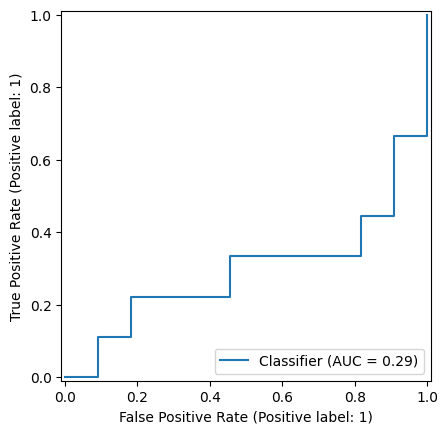

In [106]:

fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / organ / 'reg' / 'SraRunTable.txt', sep=',')
# data_eval_header = data_eval_header.loc(data_eval.index)
# print(data_eval_header.columns)
# print('ground true: ', (data_eval_header['sex'].values == 'male').astype(int))

features_fname = f"geuvadis_train_features_{sex}_calibration_{organ}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

data_eval = data_eval[features_list.index]

X_eval = data_eval.values
y_eval = data_eval_header['sex'].replace(
    {"female": "F", 'male': "M"}
).values
print(y_eval)

label_encoder = LabelEncoder().fit(y_eval)
y_eval = label_encoder.transform(y_eval)

scaler = RobustScaler().fit(X_eval)
X_eval = scaler.transform(X_eval)

# X_eval = RobustScaler().fit_transform(X_eval)

proba = np.zeros(shape=(X_eval.shape[0], 2))
pred = np.zeros(shape=(X_eval.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i in range(1):
    # saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    # model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    proba += model.predict_proba(X_eval)
    pred_ = model.predict(X_eval)
    # if sex == 'autosome':
    #     pred_ = np.abs(pred_ - 1)
    pred += pred_

    accuracies.append(accuracy_score(y_eval, pred_))
    f1.append(f1_score(y_eval, pred_))
    precisions.append(precision_score(y_eval, pred_))
    recalls.append(recall_score(y_eval, pred_))

    viz = RocCurveDisplay.from_predictions(
        y_eval, model.predict_proba(X_eval)[:, 1], ax=None
        # ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)
    
proba = proba / 5
# # pred = pred / 5
# if sex == 'autosome':
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# else:
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# # print(pred.astype(int))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

print(features_list)

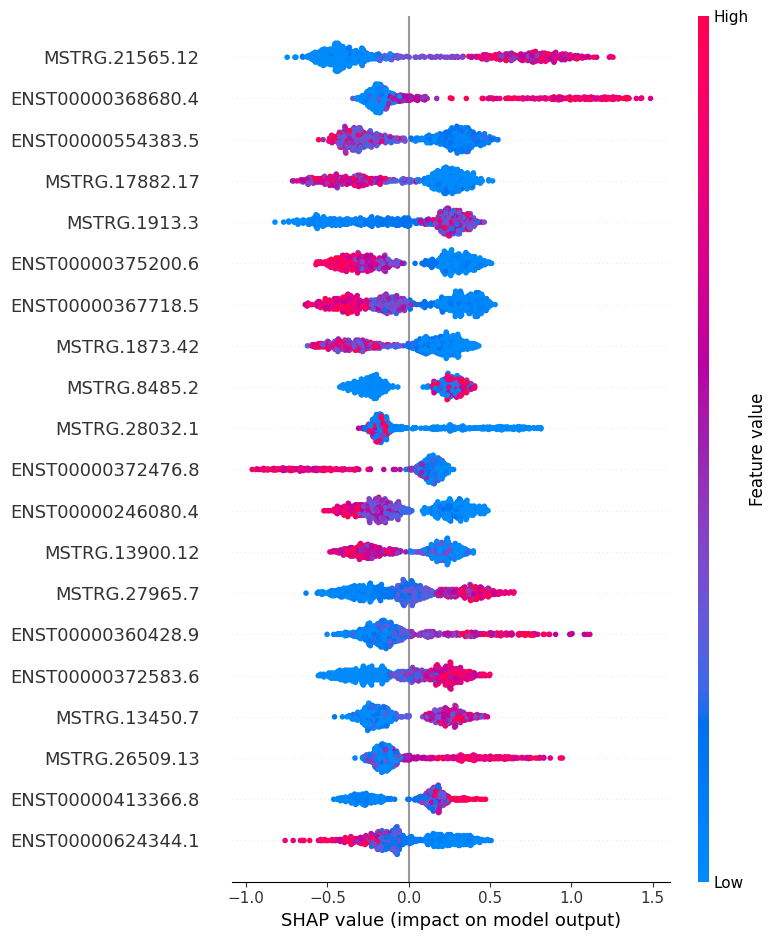

In [107]:
X_train = pd.DataFrame(data=X_train, columns=data.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=data.columns,)

# xgboost.plot_importance(model, importance_type="cover")
# shap.dependence_plot('MSTRG.36020.14', shap_values, X_train)

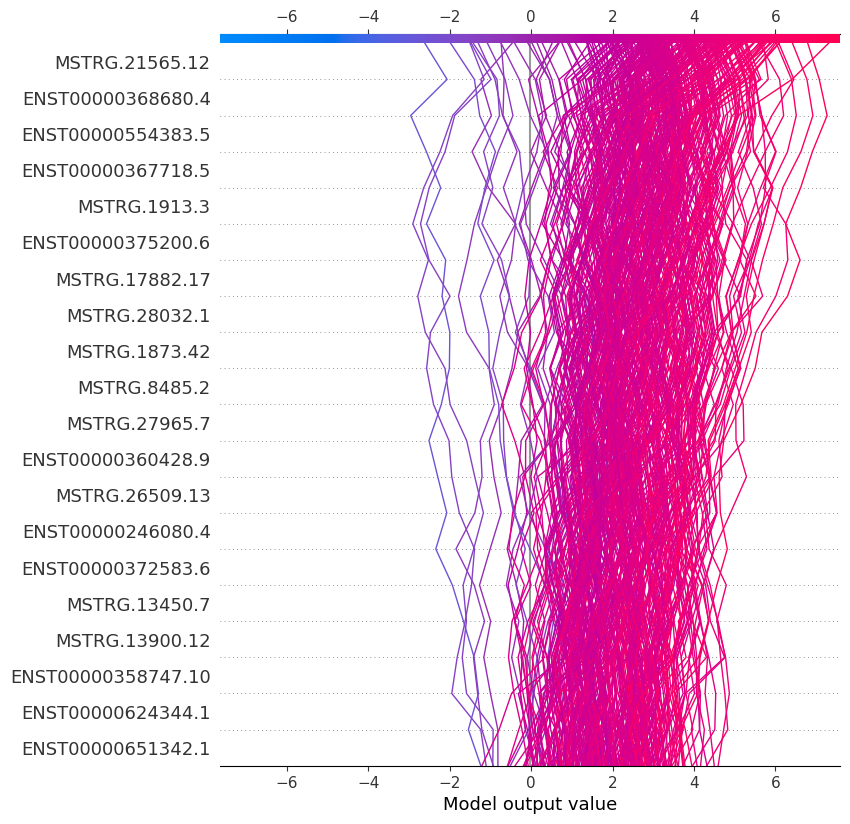

In [108]:
shap.decision_plot(explainer.expected_value, shap_values[y_train==1], X_train)
# shap.force_plot(explainer.expected_value, shap_values, X_train)


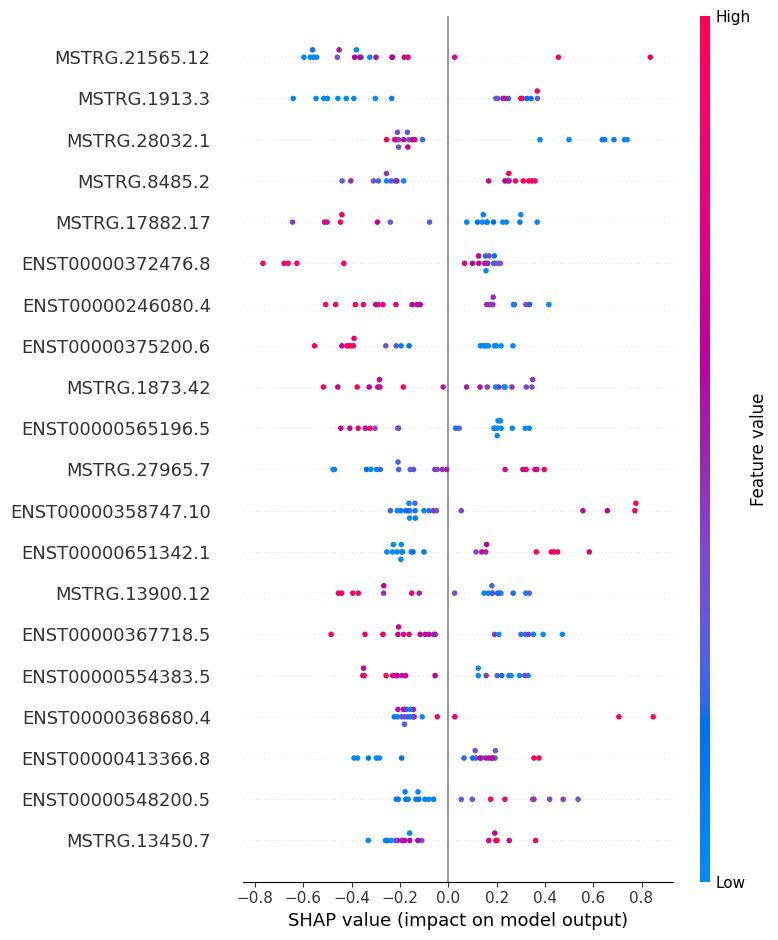

In [109]:
X_eval = pd.DataFrame(data=X_eval, columns=data_eval.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_eval)
shap.summary_plot(shap_values, X_eval, feature_names=data_eval.columns,)
# xgboost.plot_importance(model, importance_type="cover")
# shap.dependence_plot('MSTRG.36020.14', shap_values, X_eval)

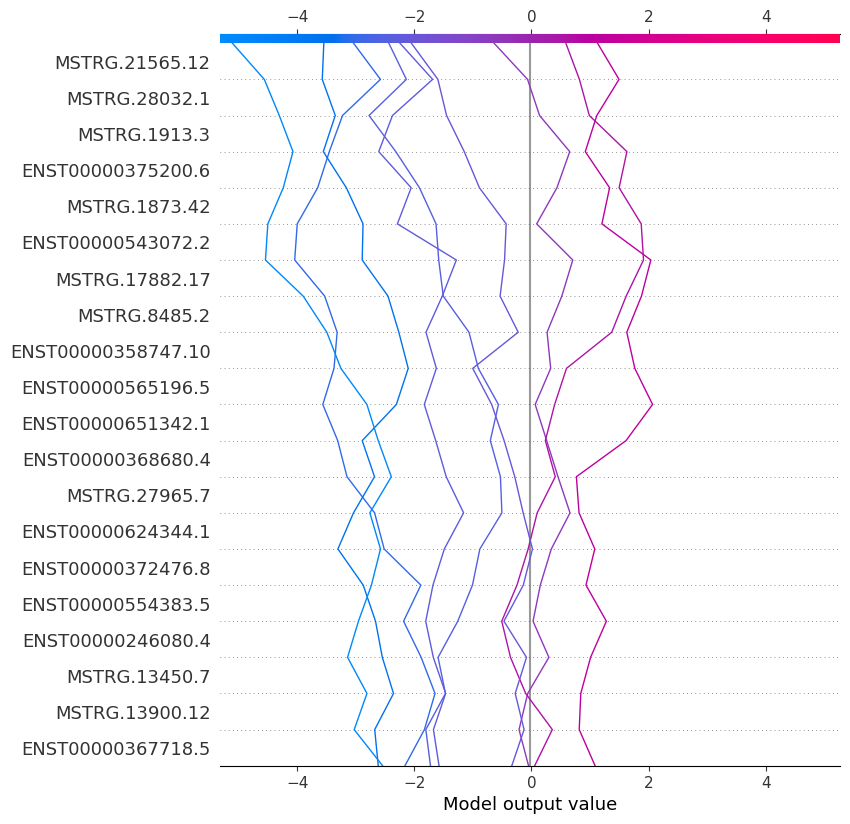

In [110]:
shap.decision_plot(explainer.expected_value, shap_values[y_eval==1], X_eval)
# shap.force_plot(explainer.expected_value, shap_values, X_eval)


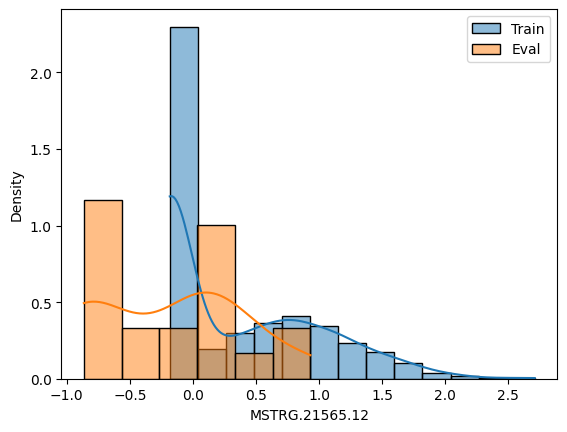

In [111]:
sns.histplot(
    X_train['MSTRG.21565.12'], kde=True, stat='density', label='Train'
    # data['MSTRG.35413.93'], kde=True, stat='density'
)
sns.histplot(
    X_eval['MSTRG.21565.12'], kde=True, stat='density', label='Eval'
    # data_eval['MSTRG.35413.93'], kde=True, stat='density'
)
plt.legend()

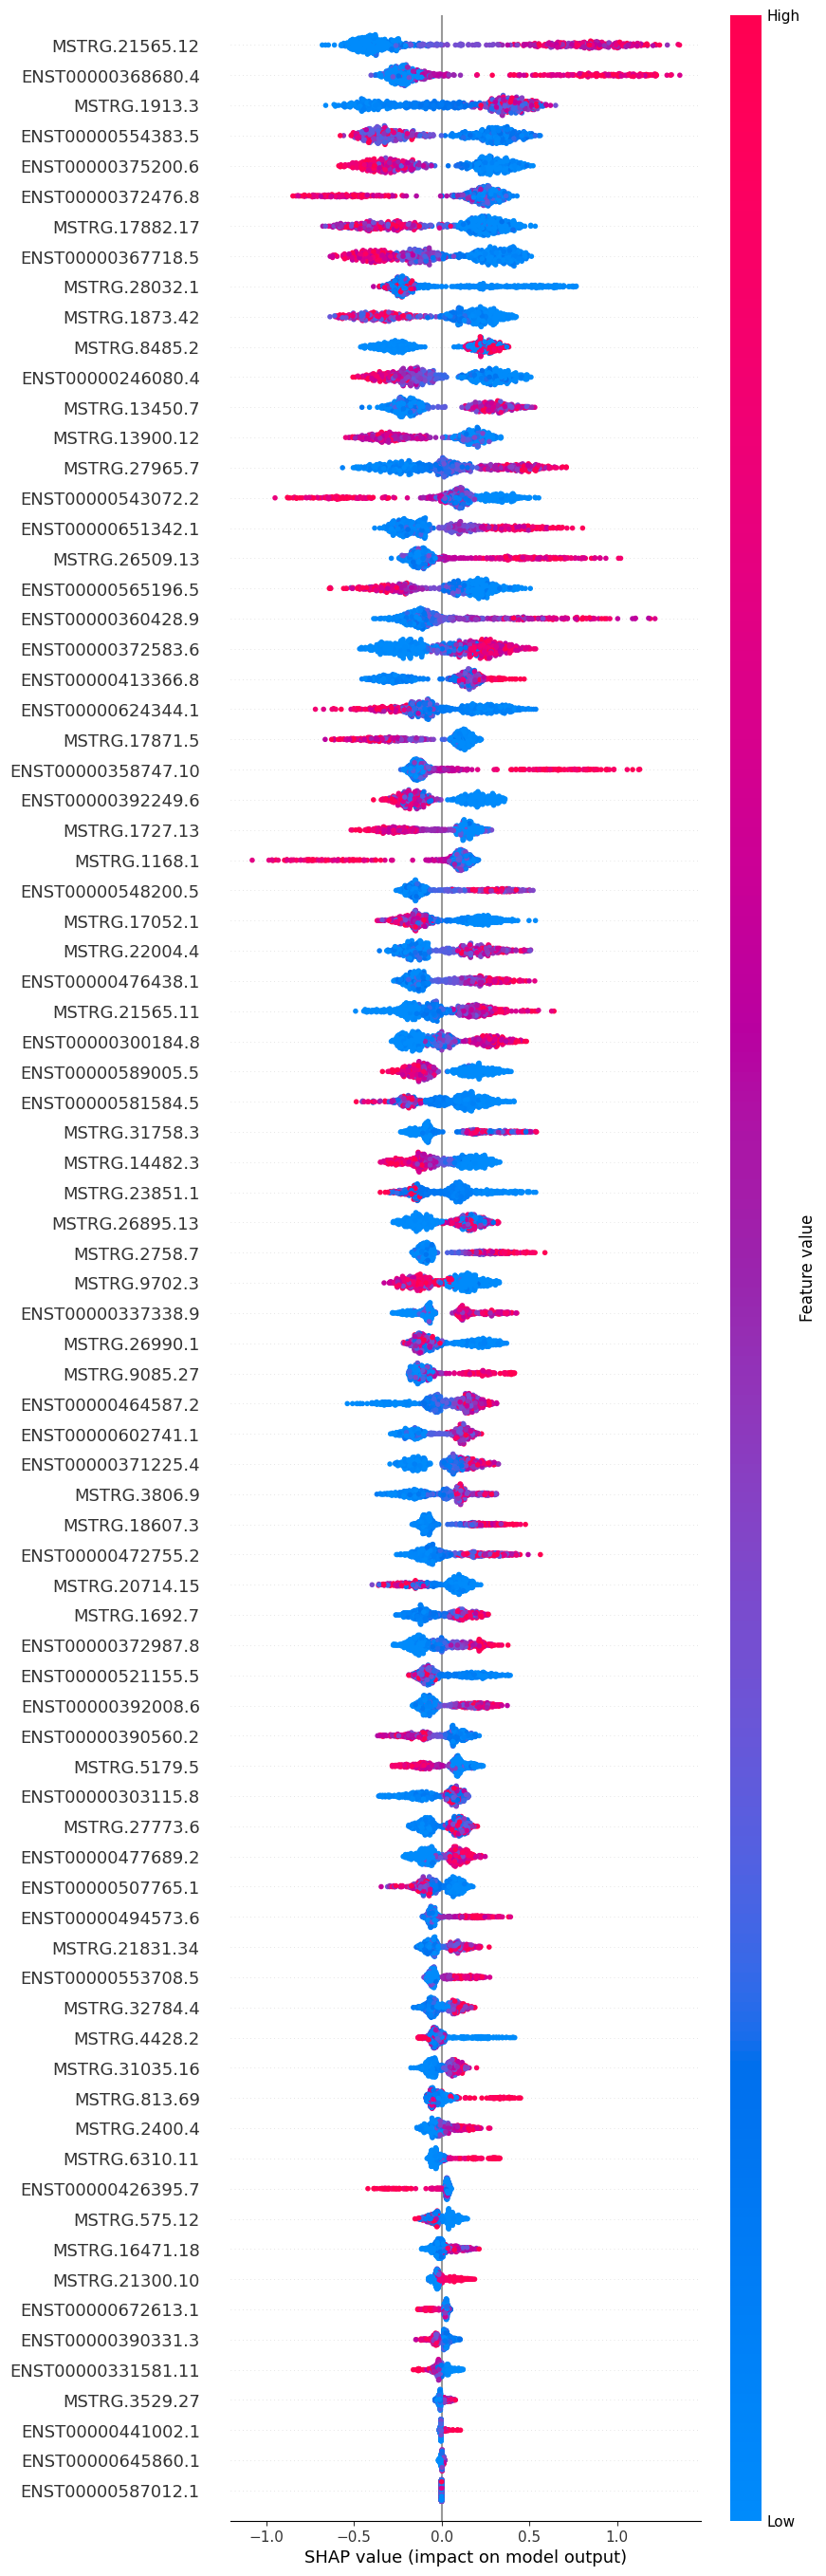

In [112]:
explainer_train = shap.Explainer(model, X_train)
shap_values_train = explainer_train(X_train)
shap.plots.beeswarm(shap_values_train, order=shap_values_train.abs.mean(0), max_display=X_train.shape[1])

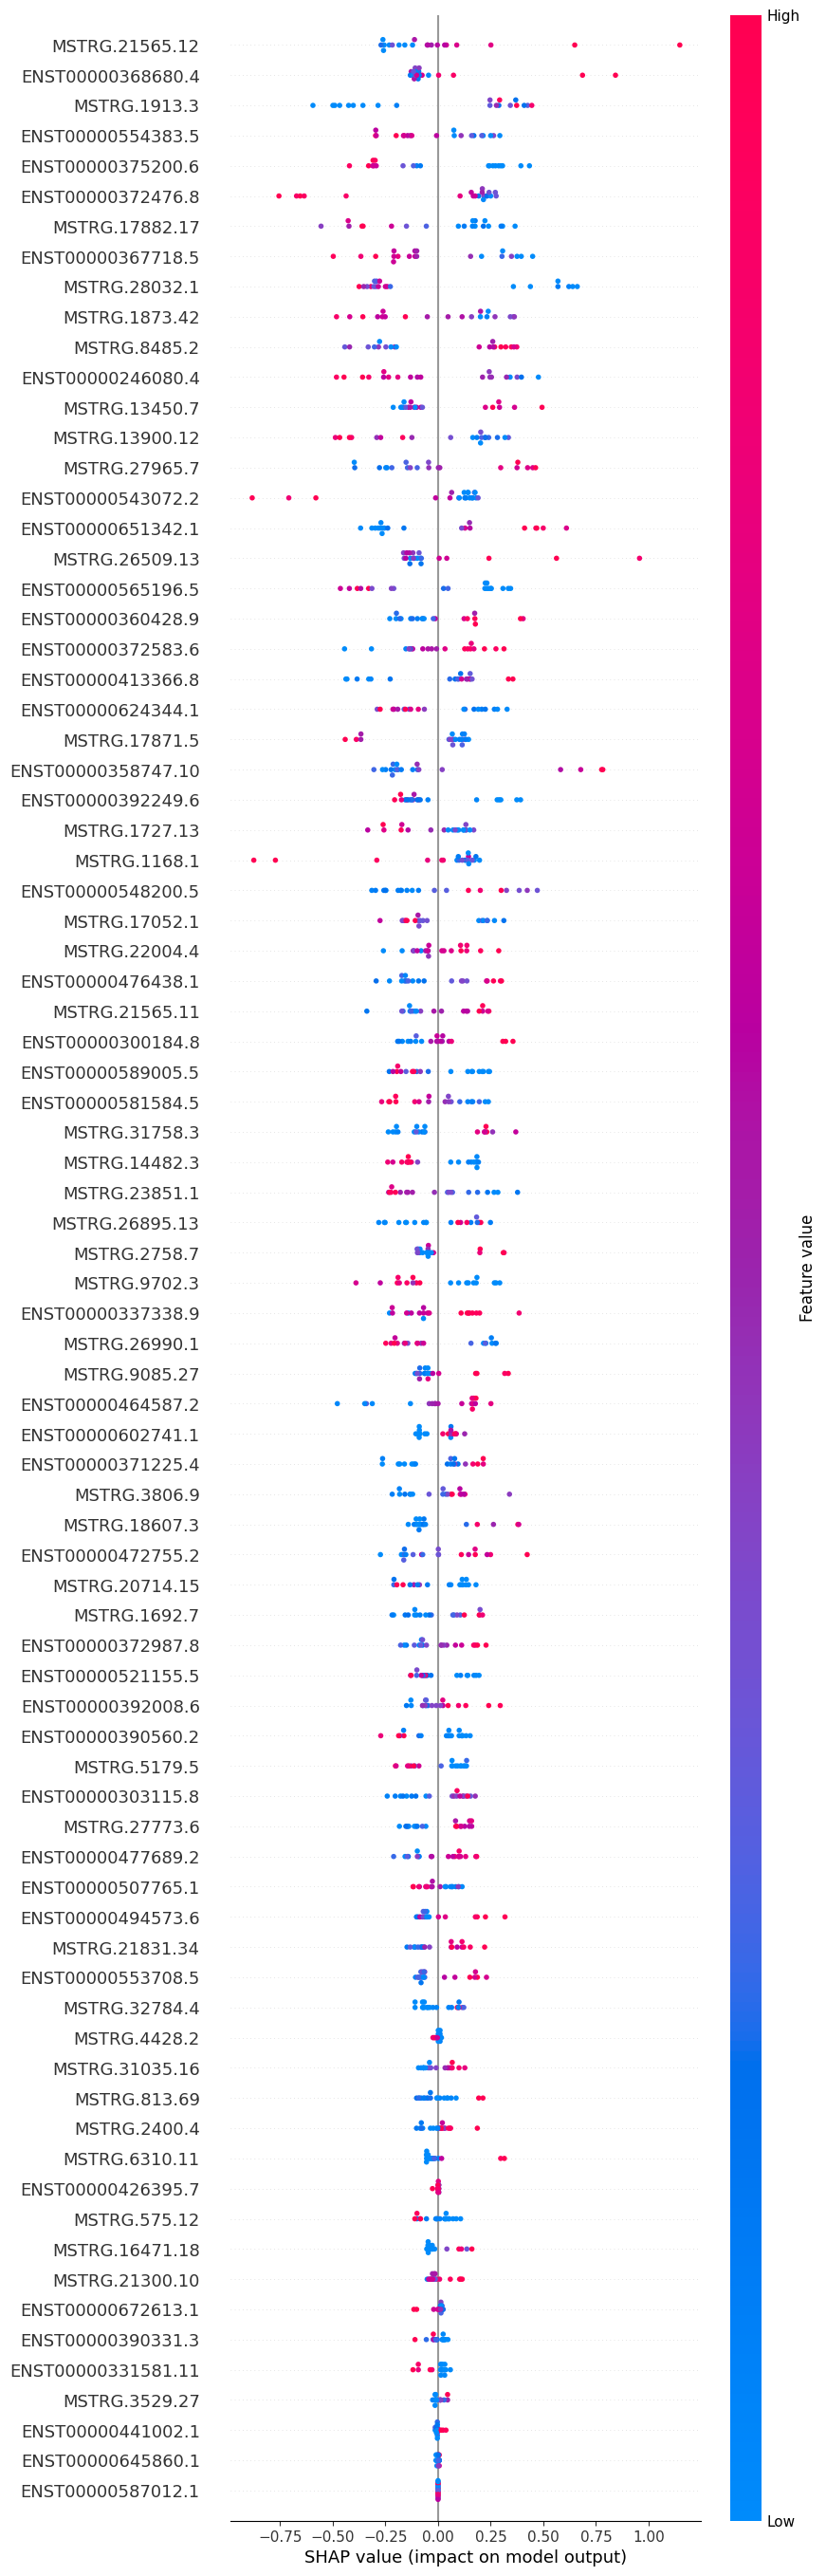

In [113]:
explainer = shap.Explainer(model, X_eval)
shap_values_eval = explainer(X_eval)
shap.plots.beeswarm(shap_values_eval, order=shap_values_train.abs.mean(0), 
                    max_display=X_eval.shape[1])

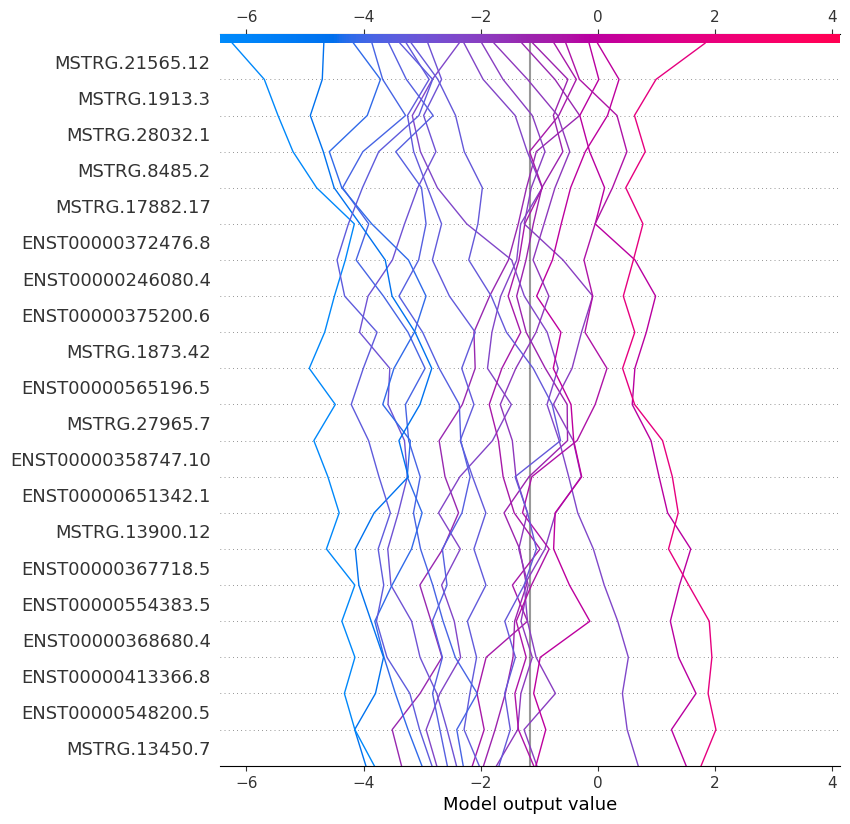

In [114]:
shap.decision_plot(explainer.expected_value, shap_values, X_eval)
